In [247]:
import numpy as np
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestClassifier 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score

#### Uploading data

In [3]:
df = pd.read_csv("dataset/preprocessed_data.csv")
df

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266,771,39,5,0.00,2,1,0,96270.64,0,1,0,0,0,1
9267,516,35,10,57369.61,1,1,1,101699.77,0,1,0,0,0,1
9268,709,36,7,0.00,1,0,1,42085.58,1,1,0,0,1,0
9269,772,42,3,75075.31,2,1,0,92888.52,1,0,1,0,0,1


#### Choosing target data and feature data

In [4]:
X = df.drop("Exited", axis=1)
X

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266,771,39,5,0.00,2,1,0,96270.64,1,0,0,0,1
9267,516,35,10,57369.61,1,1,1,101699.77,1,0,0,0,1
9268,709,36,7,0.00,1,0,1,42085.58,1,0,0,1,0
9269,772,42,3,75075.31,2,1,0,92888.52,0,1,0,0,1


In [5]:
Y = df["Exited"]
Y

0       1
1       0
2       1
3       0
4       0
       ..
9266    0
9267    0
9268    1
9269    1
9270    0
Name: Exited, Length: 9271, dtype: int64

#### Making last preparations for teaching the model

Splitting data

In [26]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.25)

Doing smote due to data disbalance

In [27]:
smote = SMOTE(random_state=42)

In [28]:
x_train, y_train = smote.fit_resample(x_train, y_train) 

#### Creating XGB model 

In [210]:
xgb = XGBClassifier(n_estimators=500, max_depth=12, learning_rate=1, objective="binary:logistic")

In [211]:
xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

##### Showing the most important features

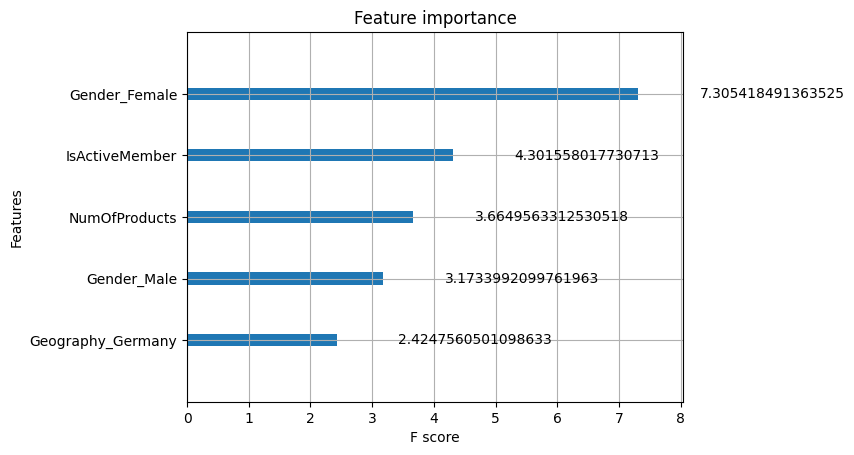

In [212]:
ax = plot_importance(xgb, importance_type="gain", max_num_features=5)
ax.figure.savefig("img/xgb_feature_importance.png")

The most important features are: 
 - Gender
 - User Activity
 - Number of products
 - Geography

In [213]:
pred = xgb.predict(x_test)

In [215]:
print(f"{accuracy_score(pred, y_test):.2f}")

0.84


Accuracy score is 0.84 which is quite a good result

#### Creating a roc_auc plot

 - getting predict probability for the plot

In [216]:
y_proba = xgb.predict_proba(x_test)[:,1]

 - getting important data for a ROC-curve

In [217]:
fpr, tpr, thereholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
xgb_auc = roc_auc

- creating the roc-curve

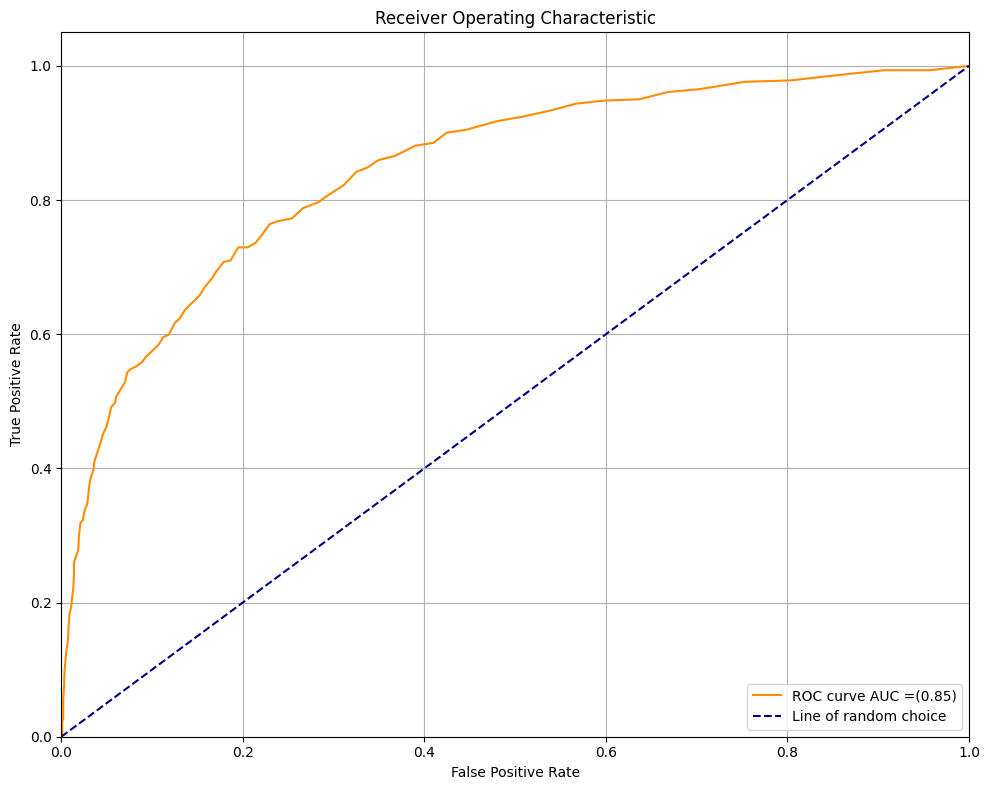

In [250]:
plt.figure(figsize=(10,8))
plt.plot(fpr,tpr, color="darkorange", label= f"ROC curve AUC =({roc_auc:.2f})")
plt.plot([0,1], [0,1], color='navy', linestyle="--", label=f"Line of random choice")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.savefig("img/XGB_ROC_plot.png")
plt.show()

The model shows good results. The accuracy is 84% successful and auc value is 0.85 
However we need to check other possibilities. Maybe there is a similar model which will perform better

#### Creating a Random Forrest Classifier

In [222]:
clf = RandomForestClassifier(random_state=42)

In [223]:
clf.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [224]:
clf_pred = clf.predict(x_test)

In [225]:
print(f"{accuracy_score(clf_pred, y_test):.2f}")

0.85


The accuracy is 0.85, the result is good and is similar to the xgb model

##### Showing the most important features for the model

In [228]:
feature_importance = clf.feature_importances_
feature_names = X.columns
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

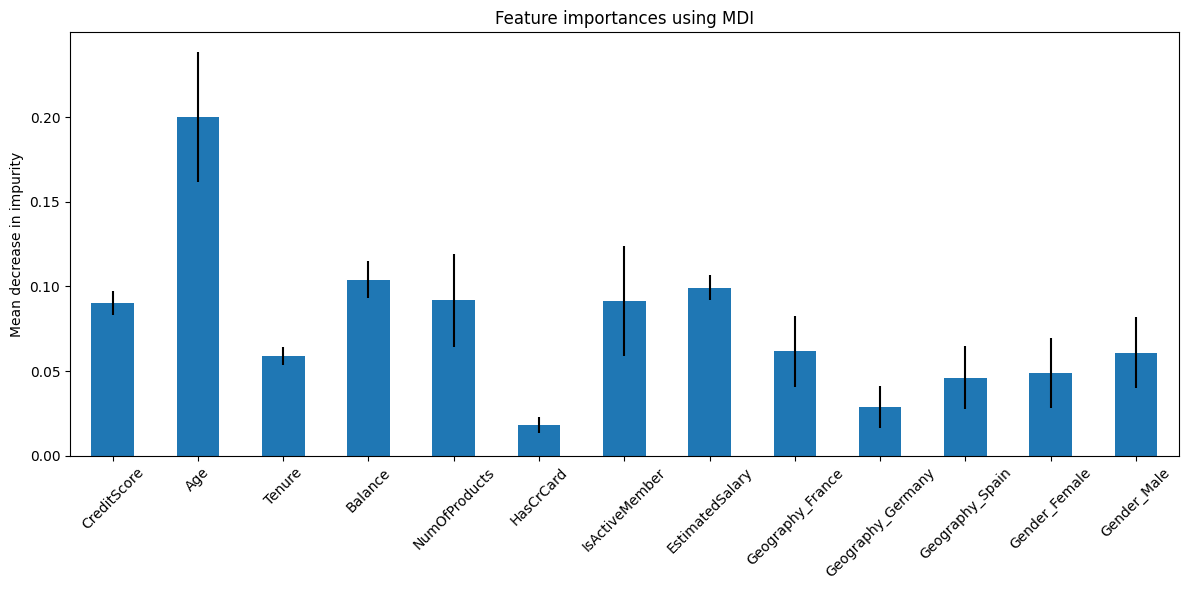

In [236]:
forest_importances = pd.Series(feature_importance, index=feature_names)
fig, ax = plt.subplots(figsize=(12,6))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.xticks(rotation=45)
plt.savefig("img/Tree_Classifier_feature_importance.png")
fig.tight_layout()

As we can see the most important features for this model are:
 - Age
 - Balance
 - Estimated Salary

Which is different from the previous model

#### Creating a ROC-curve to better represent model performance

 - getting prediction probability

In [238]:
y_predict = clf.predict_proba(x_test)[:, 1]

 - getting other data for the plot

In [240]:
fpr, tpr, thresholds = roc_curve(y_test, y_predict)
roc_auc = auc(fpr, tpr)
rf_auc = roc_auc

 - showing a ROC-curve

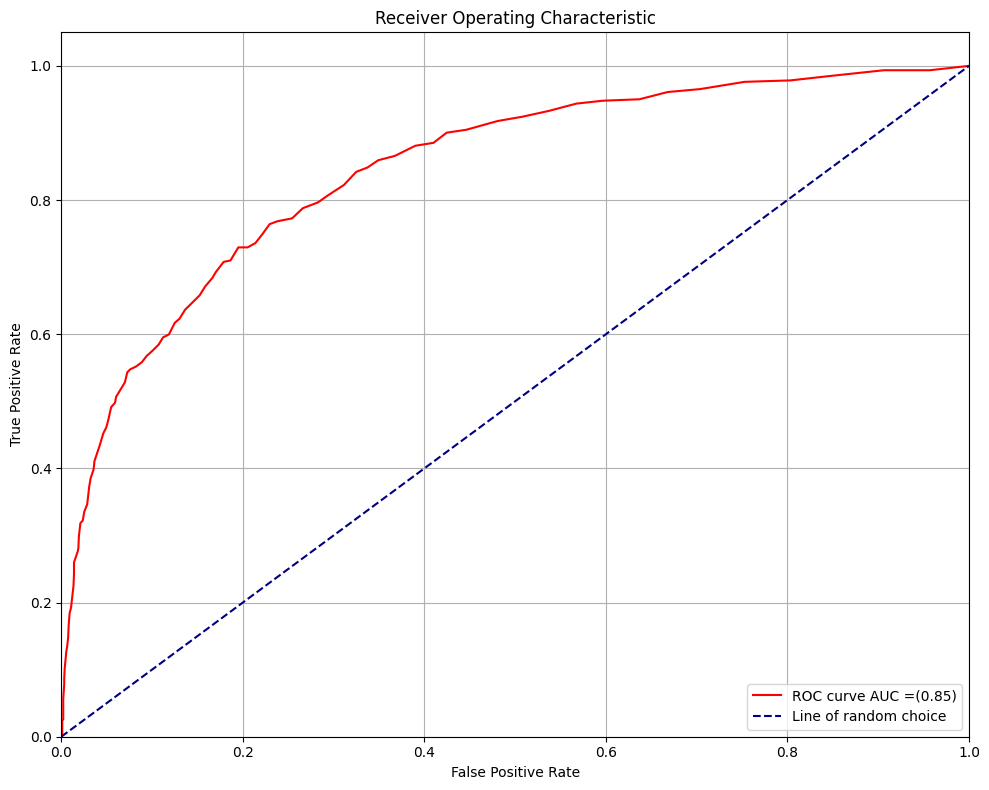

In [245]:
plt.figure(figsize=(10,8))
plt.plot(fpr,tpr, color="red", label= f"ROC curve AUC =({roc_auc:.2f})")
plt.plot([0,1], [0,1], color='navy', linestyle="--", label=f"Line of random choice")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.savefig("img/Tree_Classifier_ROC_plot.png")
plt.show()

AUC result for the Tree Classifier model is the same as for the XGB model and equals 0.85

#### Comparing models performance

In [251]:
print("XGB AUC:", xgb_auc)
print("RF AUC:", rf_auc)

if xgb_auc > rf_auc:
    print("XGBoost performed better and was selected as the final model.")
else:
    print("RandomForest performed better and was selected.")

XGB AUC: 0.824277644051351
RF AUC: 0.8454427666442752
RandomForest performed better and was selected.


#### Saving Random Forest Classifier model as the better performing model

In [248]:
joblib.dump(clf, "RandomForestModel.bin")

['RandomForestModel.bin']